In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastai.vision import *
from fastai.callbacks import *
from knockknock import email_sender

In [2]:
path = Path('.').absolute()
data_path = path / 'data256' / 'train'
model_path = path / 'models'

In [3]:
sz = 256
lr = defaults.lr
bs = 32

In [4]:
def open_div(self, fn):
    return open_mask(fn, after_open=self.after_open, div=True)

SegmentationLabelList.open = open_div

In [5]:
stats = ([0.491102, 0.491102, 0.491102], [0.24893701, 0.24893701, 0.24893701])

def label_func(o):
    return str(o).replace('train', 'masks')

data = (SegmentationItemList.from_folder(data_path)
        .split_by_rand_pct(0.2)
        .label_from_func(label_func, classes=[0, 1])
        .transform(get_transforms(), size=sz, tfm_y=True)
        .databunch(bs=bs)
        .normalize(stats))

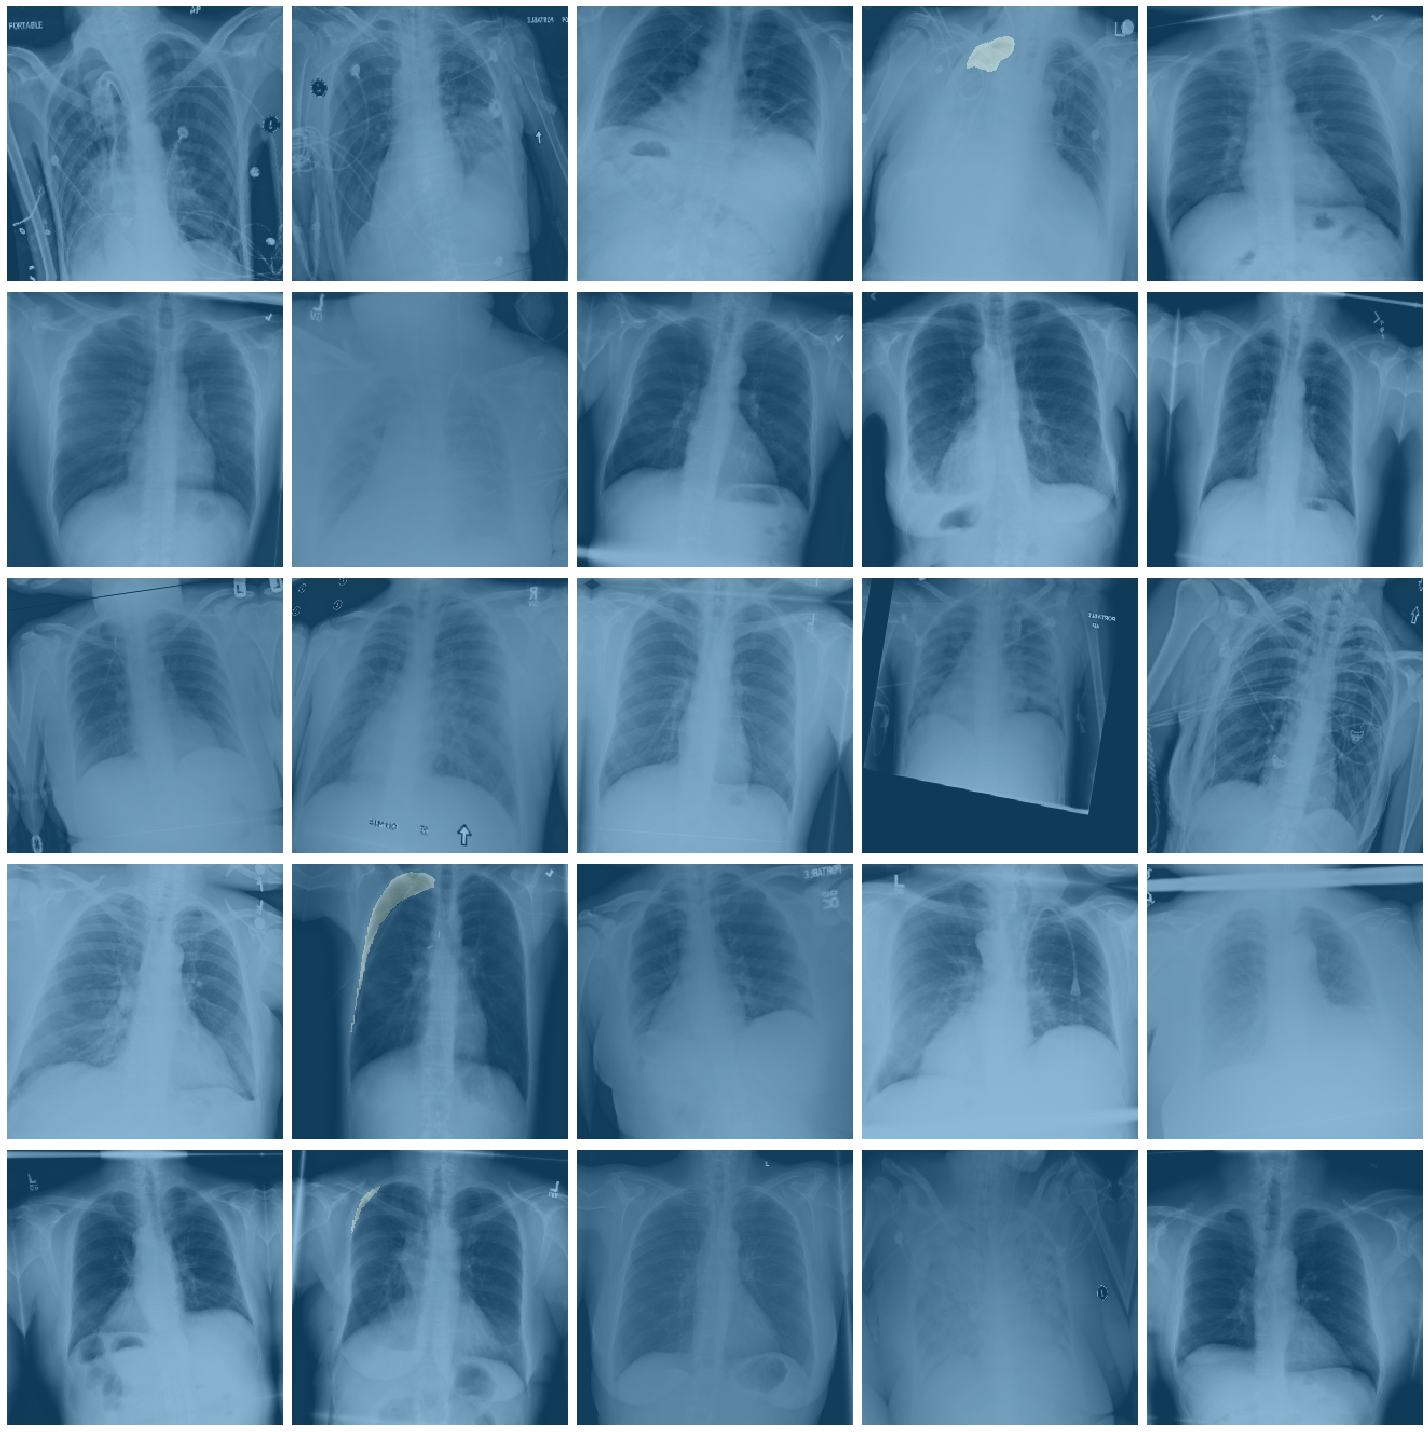

In [6]:
data.show_batch()

In [7]:
learn = unet_learner(data, 
                     models.resnet34, 
                     metrics=[dice],
                     model_dir=model_path,
                     callback_fns=[
                         partial(SaveModelCallback, monitor='dice', name='best_dice'),
                         partial(AccumulateScheduler, n_step=64 // bs),
                     ],
                    ).to_fp16()

In [8]:
@email_sender(recipient_emails=["yyang@hbku.edu.qa"], sender_email="hbkubot@gmail.com")
def train(learn, name, lr, n_epoch=5):
    learn.fit_one_cycle(n_epoch, lr)
    learn.save(name)
    return name

In [9]:
train(learn, 'stage_1', lr=lr)

epoch,train_loss,valid_loss,dice,time
0,0.021413,0.016982,0.773109,01:58
1,0.016347,0.014922,0.773109,01:52
2,0.019506,0.015200,0.773109,01:53
3,0.015337,0.014528,0.773109,01:53
4,0.014322,0.014374,0.773109,01:53


Better model found at epoch 0 with dice value: 0.7731092572212219.


'stage_1'

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 2.51E-04


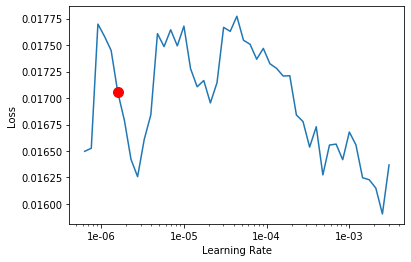

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [11]:
lr = 1e-4
train(learn, 'stage_2', lr=slice(lr/100, lr))

epoch,train_loss,valid_loss,dice,time
0,0.015606,0.014889,0.773109,02:01
1,0.013574,0.013061,0.773110,02:01
2,0.013098,0.012457,0.752404,02:00
3,0.012586,0.012379,0.760633,02:01
4,0.012791,0.012513,0.768758,02:00


Better model found at epoch 0 with dice value: 0.7731092572212219.
Better model found at epoch 1 with dice value: 0.7731096148490906.


'stage_2'

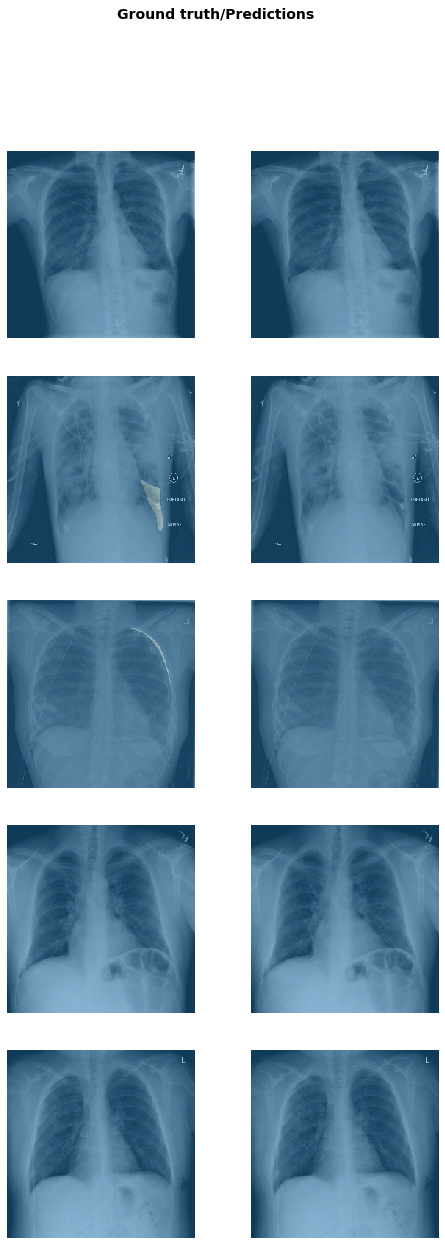

In [12]:
learn.show_results()